In [1]:
__author__ = "Jon Ball"
__version__ = "May 2024"

In [2]:
import os
import re
import json
import random
import datetime
import warnings
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
from html import unescape
import fasttext
import spacy

In [3]:
# load spacy English tokenizer
spacy_model = "en_core_web_lg"
nlp = spacy.load("en_core_web_lg")
# filter fasttext's annoying auto-warning:
# Warning : `load_model` does not return WordVectorModel or SupervisedModel any more, but a `FastText` object which is very similar.
warnings.filterwarnings("ignore")
fasttext.FastText.eprint = lambda *args, **kwargs: None
# load fasttext language classifier
fasttext_model_path = "s2_fos/data/lid.176.bin"
fasttext_model = fasttext.load_model(fasttext_model_path)

In [4]:
# spacy wrapper
def tokenize(text, tokenizer=nlp.tokenizer):
    text = text.replace("\n"," ")
    toks = tokenizer(text)
    return [tok.text for tok in toks if not tok.text.isdigit()]
# sentence tokenizer wrapping spacy, written by Weixin Liang:
# https://github.com/Weixin-Liang/Mapping-the-Increasing-Use-of-LLMs-in-Scientific-Papers/blob/main/tokenize_demo.ipynb

def sent_tokenize(text, tokenizer=nlp):
    """
    Processes the input text, splits it into sentences, and further processes each sentence
    to extract non-numeric words. It constructs a list of these words for each sentence.

    Parameters:
    text (str): A string containing multiple sentences.

    Returns:
    list: A list of lists, where each inner list contains the words from one sentence,
          excluding any numeric strings.
    """
    # remove newline characters, this line is not necessary for all cases
    # the reason it is included here is because the abstracts in the dataset contain abnormal newline characters
    # e.g. Recent works on diffusion models have demonstrated a strong capability for\nconditioning image generation,
    text = text.replace('\n',' ')
    # Initialize an empty list to store the list of words for each sentence
    sentence_list=[]
    # Process the sentence using the spacy model to extract linguistic features and split into components
    doc=tokenizer(text)
    # Iterate over each sentence in the processed text
    for sent in doc.sents:
        # Extract the words from the sentence
        words = re.findall(r'\b\w+\b', sent.text.lower())
        # Remove any words that are numeric
        words_without_digits=[word for word in words if not word.isdigit()]
        # If the list is not empty, append the list of words to the sentence_list
        if len(words_without_digits)!=0:
            sentence_list.append(words_without_digits)
    return sentence_list

In [5]:
def counts_by_month(month2articles):
        # show the number of articles per month
        edCounts = {}
        for month, articles in month2articles.items():
              edCounts[month] = len(articles)
        edCounts = pd.DataFrame(edCounts.items(), columns=["month", "count"])
        edCounts["month"] = edCounts["month"].str.replace("_", "-")
        edCounts["month"] = pd.to_datetime(edCounts["month"], format="%m-%y")
        edCounts = edCounts.sort_values(by="month")
        return edCounts

In [6]:
def plot_toks(month2articles, tokenize_func=tokenize):
    # plot the distribution of article lengths, in spacy tokens
    toks = []
    for articles in tqdm(month2articles.values()):
        toks += [len( \
            tokenize_func(article["description"][0]) \
            ) for article in articles]
    sns.histplot(toks, kde=True)

# OJS Education

## Train
2020 + 2021 data

### pre-ChatGPT: full sample of articles classified as Education (2020 - Nov 2022)

In [7]:
humEd = defaultdict(list)

Jan - Nov 2022 (validation)

In [8]:
with open(f"data/json/2022.json", "r") as infile:
    y22 = json.load(infile)

In [9]:
for articles in tqdm(y22.values()): # number of iters is number of unique OJS installations that published in 2020
    for article in articles:
        date = article.get("date", [])
        if not date:
            continue
        try:
            month = datetime.datetime.strptime(date[0], "%Y-%m-%d").month
        except ValueError:
            continue
        predicted_fos = article.get("predicted_fos", [])
        if predicted_fos and predicted_fos[0][0] == "Education" and month < 12:
            humEd[f"{month}_22"].append(article)

100%|██████████| 109672/109672 [00:17<00:00, 6387.60it/s] 


In [10]:
del y22

2021 (train)

In [11]:
with open(f"data/json/2021.json", "r") as infile:
    y21 = json.load(infile)

In [12]:
for articles in tqdm(y21.values()): # number of iters is number of unique OJS installations that published in 2021
    for article in articles:
        date = article.get("date", [])
        if not date:
            continue
        try:
            month = datetime.datetime.strptime(date[0], "%Y-%m-%d").month
        except ValueError:
            continue
        predicted_fos = article.get("predicted_fos", [])
        if predicted_fos and predicted_fos[0][0] == "Education":
            humEd[f"{month}_21"].append(article)

100%|██████████| 108532/108532 [00:22<00:00, 4855.48it/s] 


In [13]:
del y21

2020 (train)

In [14]:
with open(f"data/json/2020.json", "r") as infile:
    y20 = json.load(infile)

In [15]:
for articles in tqdm(y20.values()): # number of iters is number of unique OJS installations that published in 2020
    for article in articles:
        date = article.get("date", [])
        if not date:
            continue
        try:
            month = datetime.datetime.strptime(date[0], "%Y-%m-%d").month
        except ValueError:
            continue
        predicted_fos = article.get("predicted_fos", [])
        if predicted_fos and predicted_fos[0][0] == "Education":
            humEd[f"{month}_20"].append(article)

100%|██████████| 97117/97117 [00:21<00:00, 4414.67it/s] 


In [16]:
edCounts = counts_by_month(humEd)
edCounts

,month,count
26,2020-01-01,10118
32,2020-02-01,9078
30,2020-03-01,10391
27,2020-04-01,9732
34,2020-05-01,9794
24,2020-06-01,16820
28,2020-07-01,12189
29,2020-08-01,9838
25,2020-09-01,11669
33,2020-10-01,11292


In [17]:
edCounts["count"].sum()

509079

In [18]:
del y20

In [19]:
with open(f"data/json/humEd.json", "w") as outfile:
    json.dump(humEd, outfile)

### pre-ChatGPT: filter out articles where there are two abstracts (?? + en, where the english is possibly translated)

In [20]:
with open(f"data/json/humEd.json", "r") as infile:
    humEd = json.load(infile)

In [21]:
# remove Ed articles where the description field list contains two items
translatEd = defaultdict(list)
for month, articles in tqdm(humEd.items()):
    filtered = []
    for article in articles:
        if len(article.get("description", [])) > 1:
            translatEd[month].append(article)
        elif len(article.get("description", [])) == 1:
            filtered.append(article)
        else:
            continue
    humEd[month] = filtered

100%|██████████| 35/35 [00:01<00:00, 25.75it/s]


In [22]:
with open(f"data/json/translatEd.json", "w") as outfile:
    json.dump(translatEd, outfile)

In [23]:
edCounts = counts_by_month(humEd)
edCounts

,month,count
26,2020-01-01,5478
32,2020-02-01,5452
30,2020-03-01,6472
27,2020-04-01,5915
34,2020-05-01,5974
24,2020-06-01,9263
28,2020-07-01,6636
29,2020-08-01,5409
25,2020-09-01,6603
33,2020-10-01,6567


In [24]:
edCounts["count"].sum()

298681

### pre-ChatGPT: filter out extremely long or short abstracts

100%|██████████| 35/35 [01:50<00:00,  3.17s/it]


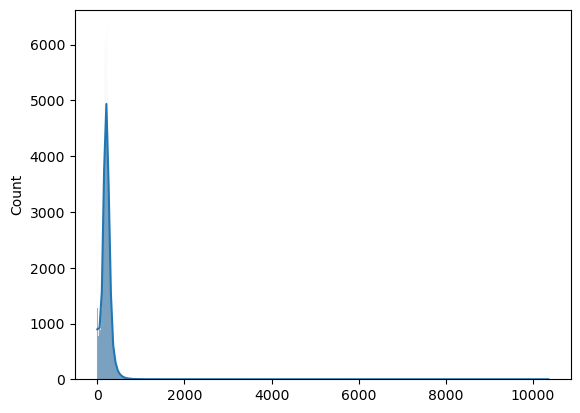

In [25]:
plot_toks(humEd)

Filter out 1% of abstracts that are outliers in terms of length

In [26]:
edtoks = [len(tokenize(article["description"][0])) for articles in tqdm(humEd.values()) for article in articles]
upper_cutoff = int(np.percentile(edtoks, 99))
lower_cutoff = int(np.percentile(edtoks, 1))
print(upper_cutoff)
print(lower_cutoff)

100%|██████████| 35/35 [01:15<00:00,  2.17s/it]

533.0
2.0


Make that 5%

In [32]:
upper_cutoff = int(np.percentile(edtoks, 99))
lower_cutoff = int(np.percentile(edtoks, 4))
print(upper_cutoff)
print(lower_cutoff)

533.0
31.0


In [33]:
# remove Ed articles where the abstract contains more / fewer tokens than cutoffs
for month, articles in tqdm(humEd.items()):
    humEd[month] = [article for article in articles if upper_cutoff > \
                     len(tokenize(article["description"][0])) \
                        > lower_cutoff]

100%|██████████| 35/35 [01:18<00:00,  2.24s/it]


In [34]:
edCounts = counts_by_month(humEd)
edCounts

,month,count
26,2020-01-01,5259
32,2020-02-01,5254
30,2020-03-01,6068
27,2020-04-01,5662
34,2020-05-01,5683
24,2020-06-01,8802
28,2020-07-01,6372
29,2020-08-01,5201
25,2020-09-01,6358
33,2020-10-01,6221


In [35]:
edCounts["count"].sum()

283602

100%|██████████| 35/35 [01:16<00:00,  2.18s/it]


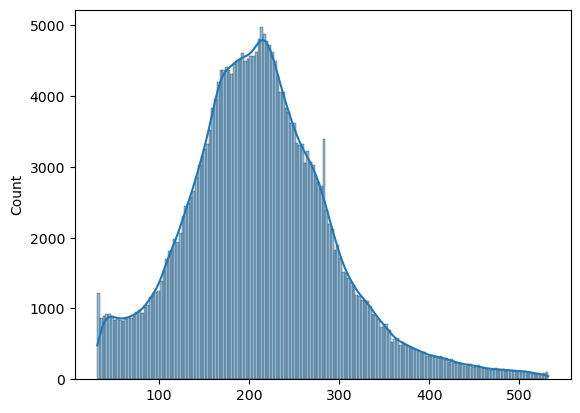

In [36]:
plot_toks(humEd)

### pre-ChatGPT: filter by s2_fos classifier confidence score (> 0.9)
... meaning the classifier, pre-trained on GPT-4-labeled data by AI2 / Semantic Scholar, predicts Education over 20 field of study categories with >90% confidence

In [37]:
for month, articles in tqdm(humEd.items()):
    humEd[month] = [article for article in articles if \
                    article.get("predicted_fos", []) and \
                    article["predicted_fos"][0][0] == "Education" and \
                    article["predicted_fos"][0][1] > 0.9]

100%|██████████| 35/35 [00:02<00:00, 13.51it/s]


In [38]:
counts_by_month(humEd)

,month,count
26,2020-01-01,1178
32,2020-02-01,1212
30,2020-03-01,1405
27,2020-04-01,1209
34,2020-05-01,1517
24,2020-06-01,1992
28,2020-07-01,1479
29,2020-08-01,1206
25,2020-09-01,1548
33,2020-10-01,1503


In [39]:
counts_by_month(humEd)["count"].sum()

72222

100%|██████████| 35/35 [00:18<00:00,  1.87it/s]


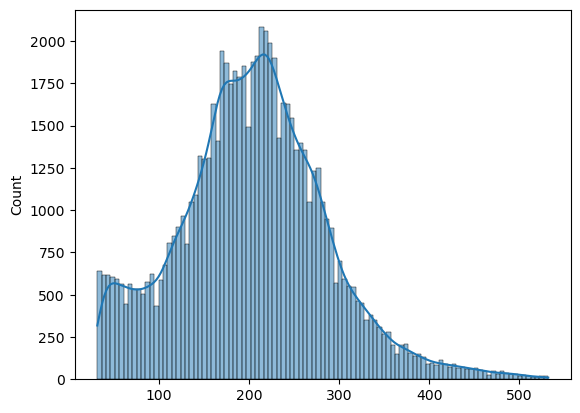

In [40]:
plot_toks(humEd)

In [41]:
print(humEd.keys())

dict_keys(['4_22', '9_22', '2_22', '10_22', '5_22', '7_22', '8_22', '6_22', '3_22', '11_22', '1_22', '7_21', '2_21', '11_21', '9_21', '8_21', '4_21', '6_21', '12_21', '5_21', '3_21', '10_21', '1_21', '12_20', '6_20', '9_20', '1_20', '4_20', '7_20', '8_20', '3_20', '11_20', '2_20', '10_20', '5_20'])


### save!

In [42]:
with open("data/json/humEd.json", "w") as outfile:
    json.dump(humEd, outfile)

### Human corpus: train split

#### 2021 monolingual English abstracts

In [7]:
with open("data/json/humEd.json", "r") as infile:
    humEd = json.load(infile)

In [8]:
train = [] # 2021
for month, articles in humEd.items():
    if month.endswith("21"):
        for article in articles:
            train.append(unescape(article["description"][0]))
print(f"train: {len(train)}") # 2021

train: 27010


sent_tokenize the human training corpus

In [9]:
train_corpus = [sent_tokenize(abstract) for abstract in tqdm(train)]
print(f"abstracts: {len(train_corpus)}") # 2021
print(f"sentences: {sum(len(abstract) for abstract in train_corpus)}")
print(train_corpus[0])

100%|██████████| 27010/27010 [12:28<00:00, 36.08it/s]

abstracts: 27010
sentences: 215536
[['this', 'research', 'departs', 'from', 'the', 'lack', 'of', 'teacher', 'ability', 'in', 'making', 'learning', 'planning', 'administration', 'app', 'that', 'matches', 'the', 'instrument', 'of', 'acridiation', 'in'], ['it', 'was', 'discovered', 'when', 'carrying', 'out', 'coaching', 'tasks', 'to', 'teachers', 'in', 'target', 'schools'], ['there', 'are', 'still', 'many', 'teachers', 'who', 'do', 'not', 'understand', 'what', 'it', 'takes', 'to', 'create', 'an', 'app'], ['therefore', 'this', 'study', 'aims', 'to', 'improve', 'the', 'ability', 'of', 'teachers', 'in', 'making', 'app', 'according', 'to', 'the', 'instrument', 'of', 'akriditasi', 'and', 'improved', 'teacher', 'ability', 'to', 'make', 'app', 'according', 'to', 'acrydition', 'instrument'], ['the', 'research', 'method', 'used', 'is', 'school', 'action', 'research', 'pts'], ['the', 'stages', 'of', 'the', 'method', 'are', 'planning', 'implementation', 'reflection', 'and', 'observations'], ['after'

Mean length of human-written abstracts, in sentences: 7.979859311366161
Median length of human-written abstracts, in sentences: 8


<Axes: ylabel='Count'>

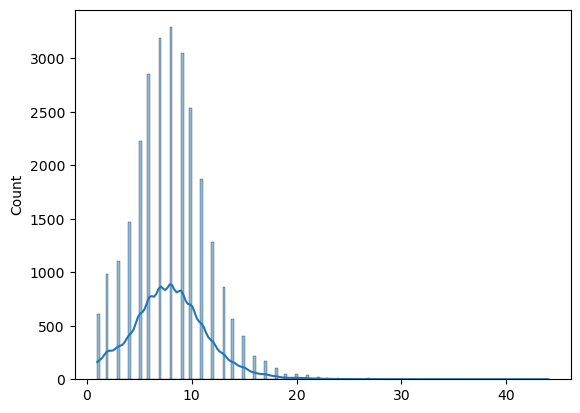

In [10]:
abstract_lens = [len(abstract) for abstract in train_corpus]
print(f"Mean length of human-written abstracts, in sentences: {np.mean(abstract_lens)}")
print(f"Median length of human-written abstracts, in sentences: {int(np.median(abstract_lens))}")
sns.histplot(abstract_lens, kde=True) # in sentences

In [11]:
# unpack the train corpus into a list of sentences
train_sents = [sent for abstract in train_corpus for sent in abstract if len(sent) > 1]
print(train_sents[-1])

['the', 'study', 'recommended', 'that', 'in', 'order', 'to', 'implement', 'sports', 'and', 'games', 'in', 'public', 'secondary', 'schools', 'government', 'should', 'promote', 'good', 'policies', 'which', 'favor', 'sports', 'and', 'games', 'in', 'secondary', 'schools', 'and', 'establishing', 'sports', 'and', 'games', 'academy', 'for', 'children', 'may', 'help', 'others', 'to', 'grow', 'up', 'with', 'their', 'carrier']


Mean length of human-written sentences, in tokens: 23.017481426275705
Median length of human-written sentences, in tokens: 21


<Axes: ylabel='Count'>

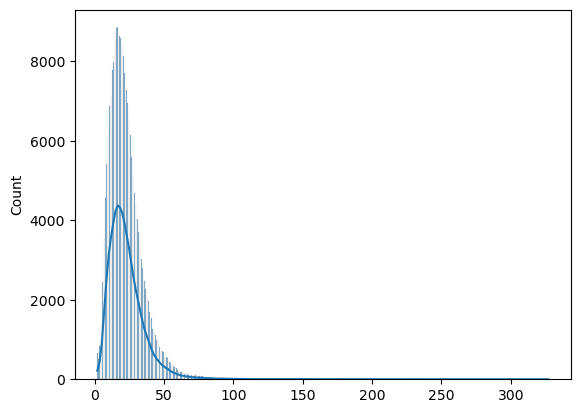

In [12]:
sent_lens = [len(sent) for sent in train_sents]
print(f"Mean length of human-written sentences, in tokens: {np.mean(sent_lens)}")
print(f"Median length of human-written sentences, in tokens: {int(np.median(sent_lens))}")
sns.histplot(sent_lens, kde=True) # in tokens

Sentences above 69 tokens removed.
Remaining sentences: 212521


<Axes: ylabel='Count'>

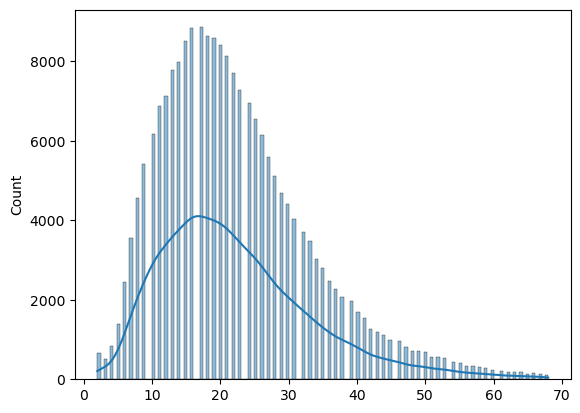

In [13]:
# clip the top 1% of sentence lengths
upper_cutoff = int(np.percentile(sent_lens, 99))
# filter out sentences above the cutoff
train_sents = [sent for sent in train_sents if len(sent) < upper_cutoff]
print(f"Sentences above {upper_cutoff} tokens removed.")
print(f"Remaining sentences: {len(train_sents)}")
sent_lens = [len(sent) for sent in train_sents]
sns.histplot(sent_lens, kde=True) # in tokens

In [14]:
humEd_train = pd.DataFrame({"human_sentence": train_sents})
humEd_train.head()

,human_sentence
0,"[this, research, departs, from, the, lack, of,..."
1,"[it, was, discovered, when, carrying, out, coa..."
2,"[there, are, still, many, teachers, who, do, n..."
3,"[therefore, this, study, aims, to, improve, th..."
4,"[the, research, method, used, is, school, acti..."


In [15]:
humEd_train.to_parquet("data/training_data/ojs_ed/human_data_21.parquet")

#### 2021 translated abstracts

In [16]:
with open("data/json/engEd.json", "r") as infile:
    engEd = json.load(infile)

In [17]:
train = [] # 2021
for month, articles in engEd.items():
    if month.endswith("21"):
        for article in articles:
            train.append(unescape(article["description"][0]))
print(f"abstracts translated into English: {len(train)}") # 2021

abstracts translated into English: 21381


sent tokenize the translated abstracts

In [18]:
train_corpus = [sent_tokenize(abstract) for abstract in tqdm(train)]
print(f"abstracts: {len(train_corpus)}") # 2021
print(f"sentences: {sum(len(abstract) for abstract in train_corpus)}")
print(train_corpus[0])

100%|██████████| 21381/21381 [09:54<00:00, 35.94it/s]

abstracts: 21381
sentences: 145311
[['the', 'result', 'of', 'research', 'on', 'dytectiveu', 'application', 'and', 'its', 'contribution', 'to', 'the', 'reading', 'writing', 'process', 'in', 'children', 'with', 'dyslexia', 'is', 'offered'], ['an', 'explanatory', 'descriptive', 'research', 'was', 'developed', 'with', 'the', 'use', 'of', 'quantitative', 'and', 'qualitative', 'methods', 'to', 'explore', 'the', 'reading', 'writing', 'process', 'mediated', 'by', 'technologies', 'of', 'the', 'education'], ['it', 'was', 'found', 'that', 'the', 'dytectiveu', 'application', 'offers', 'multiple', 'actions', 'to', 'learn', 'to', 'read', 'and', 'write', 'during', 'the', 'learning', 'of', 'children', 'with', 'dyslexia'], ['it', 'concludes', 'that', 'the', 'dytectiveu', 'application', 'reveals', 'potentialities', 'to', 'develop', 'the', 'literacy', 'process', 'in', 'children', 'with', 'dyslexia', 'as', 'well', 'as', 'the', 'reasons', 'that', 'lead', 'to', 'its', 'use', 'in', 'the', 'teaching', 'learni

Mean length of human-written abstracts, in sentences: 6.796267714325803
Median length of human-written abstracts, in sentences: 6


<Axes: ylabel='Count'>

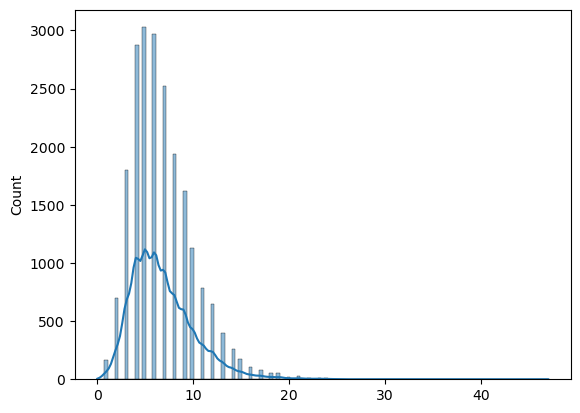

In [19]:
abstract_lens = [len(abstract) for abstract in train_corpus]
print(f"Mean length of human-written abstracts, in sentences: {np.mean(abstract_lens)}")
print(f"Median length of human-written abstracts, in sentences: {int(np.median(abstract_lens))}")
sns.histplot(abstract_lens, kde=True) # in sentences

In [20]:
# unpack the train corpus into a list of sentences
train_sents = [sent for abstract in train_corpus for sent in abstract if len(sent) > 1]
print(train_sents[-1])

['keywords', 'virtual', 'learning', 'environments', 'role', 'of', 'the', 'teacher', 'role', 'of', 'the', 'student', 'technological', 'tools']


Mean length of human-written sentences, in tokens: 28.004141822679955
Median length of human-written sentences, in tokens: 25


<Axes: ylabel='Count'>

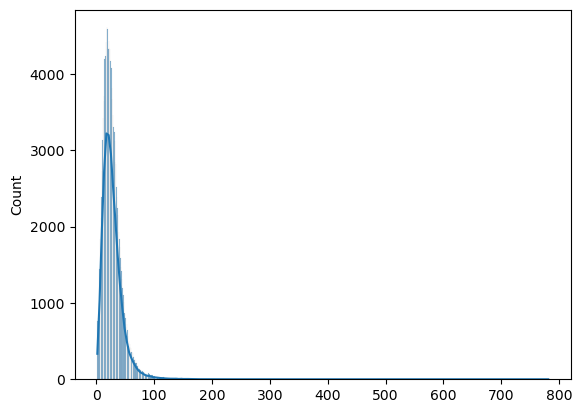

In [21]:
sent_lens = [len(sent) for sent in train_sents]
print(f"Mean length of human-written sentences, in tokens: {np.mean(sent_lens)}")
print(f"Median length of human-written sentences, in tokens: {int(np.median(sent_lens))}")
sns.histplot(sent_lens, kde=True) # in tokens

Sentences above 91 tokens removed.
Remaining sentences: 142424


<Axes: ylabel='Count'>

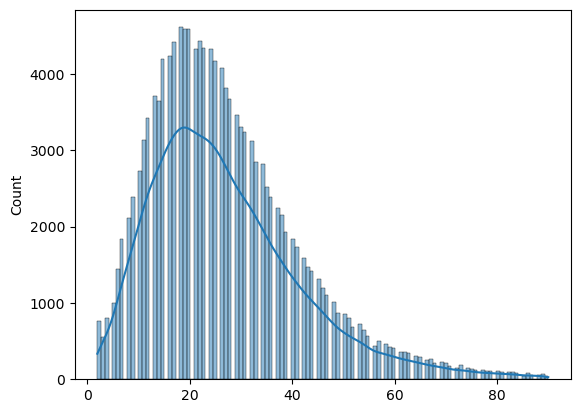

In [22]:
# clip the top 1% of sentence lengths
upper_cutoff = int(np.percentile(sent_lens, 99))
# filter out sentences above the cutoff
train_sents = [sent for sent in train_sents if len(sent) < upper_cutoff]
print(f"Sentences above {upper_cutoff} tokens removed.")
print(f"Remaining sentences: {len(train_sents)}")
sent_lens = [len(sent) for sent in train_sents]
sns.histplot(sent_lens, kde=True) # in tokens

In [23]:
translatEd_train = pd.DataFrame({"human_sentence": train_sents})
translatEd_train.head()

,human_sentence
0,"[the, result, of, research, on, dytectiveu, ap..."
1,"[an, explanatory, descriptive, research, was, ..."
2,"[it, was, found, that, the, dytectiveu, applic..."
3,"[it, concludes, that, the, dytectiveu, applica..."
4,"[the, article, gives, a, public, mention, of, ..."


In [24]:
translatEd_train.to_parquet("data/training_data/ojs_ed/human_data_translated_21.parquet")

#### 2020 monolingual English abstracts

In [25]:
with open("data/json/humEd.json", "r") as infile:
    humEd = json.load(infile)

In [26]:
train = [] # 2020
for month, articles in humEd.items():
    if month.endswith("20"):
        for article in articles:
            train.append(unescape(article["description"][0]))
print(f"train: {len(train)}") # 2020

train: 19118


sent_tokenize the human training corpus

In [27]:
train_corpus = [sent_tokenize(abstract) for abstract in tqdm(train)]
print(f"abstracts: {len(train_corpus)}") # 2021
print(f"sentences: {sum(len(abstract) for abstract in train_corpus)}")
print(train_corpus[0])

100%|██████████| 19118/19118 [08:25<00:00, 37.83it/s]

abstracts: 19118
sentences: 155113
[['being', 'accepted', 'as', 'out', 'of', 'the', 'four', 'essential', 'language', 'skills', 'in', 'the', 'language', 'learning', 'process', 'writing', 'seems', 'to', 'be', 'difficult', 'for', 'numerous', 'efl', 'learners'], ['this', 'research', 'is', 'an', 'endeavor', 'to', 'explore', 'if', 'learners', 'can', 'grow', 'out', 'of', 'the', 'writing', 'difficulties', 'with', 'topic', 'based', 'writing', 'activity'], ['third', 'year', 'students', 'at', 'the', 'faculty', 'of', 'foreign', 'languages', 'of', 'phan', 'thiet', 'university', 'in', 'phan', 'thiet', 'city', 'binh', 'thuan', 'province', 'participated', 'in', 'the', 'study'], ['these', 'students', 'were', 'in', 'the', 'two', 'writing', 'classes', 'one', 'class', 'was', 'treated', 'as', 'the', 'experimental', 'group', 'eg', 'and', 'the', 'other', 'as', 'the', 'control', 'group', 'cg'], ['research', 'findings', 'exposed', 'the', 'benefits', 'of', 'topic', 'based', 'writing', 'activity', 'in', 'nurturi

Mean length of human-written abstracts, in sentences: 8.113453290093107
Median length of human-written abstracts, in sentences: 8


<Axes: ylabel='Count'>

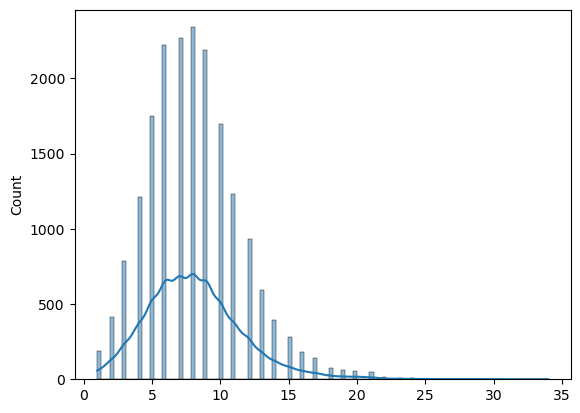

In [28]:
abstract_lens = [len(abstract) for abstract in train_corpus]
print(f"Mean length of human-written abstracts, in sentences: {np.mean(abstract_lens)}")
print(f"Median length of human-written abstracts, in sentences: {int(np.median(abstract_lens))}")
sns.histplot(abstract_lens, kde=True) # in sentences

In [29]:
# unpack the train corpus into a list of sentences
train_sents = [sent for abstract in train_corpus for sent in abstract if len(sent) > 1]
print(train_sents[-1])

['the', 'study', 'suggested', 'educational', 'curriculum', 'needs', 'to', 'be', 'reviewed', 'to', 'meet', 'the', 'demand', 'of', 'the', 'people', 'commence', 'an', 'intensive', 'mentoring', 'programs', 'by', 'formulating', 'link', 'with', 'other', 'industry', 'investors', 'alumni', 'professional', 'and', 'business', 'professions', 'so', 'that', 'university', 'learners', 'can', 'acquire', 'knowledge', 'and', 'skills', 'for', 'industrial', 'development']


Mean length of human-written sentences, in tokens: 23.094832665376074
Median length of human-written sentences, in tokens: 21


<Axes: ylabel='Count'>

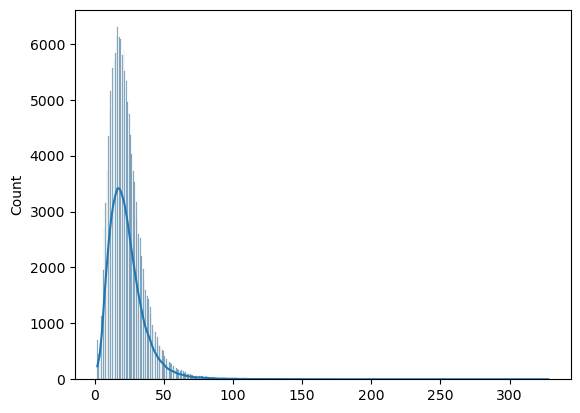

In [30]:
sent_lens = [len(sent) for sent in train_sents]
print(f"Mean length of human-written sentences, in tokens: {np.mean(sent_lens)}")
print(f"Median length of human-written sentences, in tokens: {int(np.median(sent_lens))}")
sns.histplot(sent_lens, kde=True) # in tokens

Sentences above 69 tokens removed.
Remaining sentences: 152838


<Axes: ylabel='Count'>

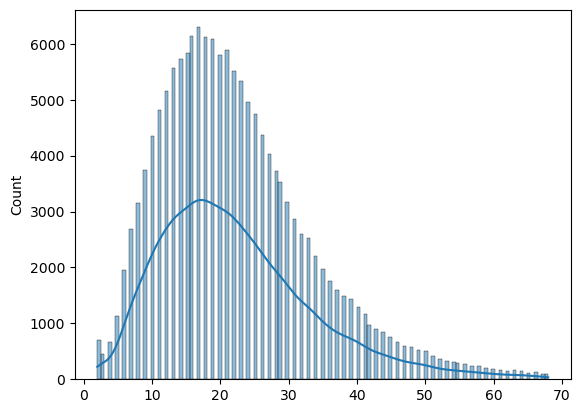

In [31]:
# clip the top 1% of sentence lengths
upper_cutoff = int(np.percentile(sent_lens, 99))
# filter out sentences above the cutoff
train_sents = [sent for sent in train_sents if len(sent) < upper_cutoff]
print(f"Sentences above {upper_cutoff} tokens removed.")
print(f"Remaining sentences: {len(train_sents)}")
sent_lens = [len(sent) for sent in train_sents]
sns.histplot(sent_lens, kde=True) # in tokens

In [32]:
humEd_train = pd.DataFrame({"human_sentence": train_sents})
humEd_train.head()

,human_sentence
0,"[being, accepted, as, out, of, the, four, esse..."
1,"[this, research, is, an, endeavor, to, explore..."
2,"[third, year, students, at, the, faculty, of, ..."
3,"[these, students, were, in, the, two, writing,..."
4,"[research, findings, exposed, the, benefits, o..."


In [33]:
humEd_train.to_parquet("data/training_data/ojs_ed/human_data_20.parquet")

#### 2020 translated abstracts

In [34]:
with open("data/json/engEd.json", "r") as infile:
    engEd = json.load(infile)

In [35]:
train = [] # 2020
for month, articles in engEd.items():
    if month.endswith("20"):
        for article in articles:
            train.append(unescape(article["description"][0]))
print(f"abstracts translated into English: {len(train)}") # 2020

abstracts translated into English: 16483


sent tokenize the translated abstracts

In [36]:
train_corpus = [sent_tokenize(abstract) for abstract in tqdm(train)]
print(f"abstracts: {len(train_corpus)}") # 2021
print(f"sentences: {sum(len(abstract) for abstract in train_corpus)}")
print(train_corpus[0])

100%|██████████| 16483/16483 [07:25<00:00, 36.96it/s]

abstracts: 16483
sentences: 111921
[['the', 'current', 'study', 'investigated', 'strategies', 'that', 'non', 'native', 'english', 'majors', 'used', 'in', 'learning', 'english'], ['in', 'particular', 'the', 'study', 'aimed', 'at', 'finding', 'the', 'metacognitive', 'learning', 'strategies', 'cognitive', 'learning', 'strategies', 'affective', 'learning', 'strategies', 'and', 'socio', 'interactive', 'learning', 'strategies', 'and', 'tactics', 'that', '4th', 'year', 'english', 'major', 'university', 'students', 'used', 'to', 'help', 'them', 'become', 'autonomous', 'learners'], ['a', 'sample', 'of', 'participants', 'was', 'chosen', 'randomly', 'to', 'participate', 'in', 'the', 'study', 'from', 'a', 'population', 'of', 'students'], ['semi', 'structured', 'interviews', 'were', 'used', 'to', 'collect', 'the', 'study', 'data'], ['the', 'thematic', 'analysis', 'qualitative', 'method', 'was', 'used', 'to', 'analyze', 'the', 'collected', 'data'], ['results', 'showed', 'that', 'the', 'participants'

Mean length of human-written abstracts, in sentences: 6.790086756051689
Median length of human-written abstracts, in sentences: 6


<Axes: ylabel='Count'>

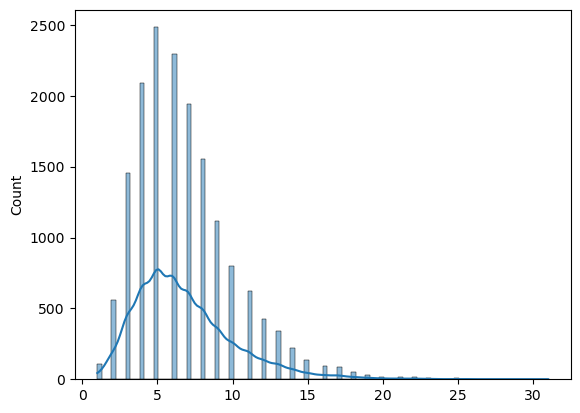

In [37]:
abstract_lens = [len(abstract) for abstract in train_corpus]
print(f"Mean length of human-written abstracts, in sentences: {np.mean(abstract_lens)}")
print(f"Median length of human-written abstracts, in sentences: {int(np.median(abstract_lens))}")
sns.histplot(abstract_lens, kde=True) # in sentences

In [38]:
# unpack the train corpus into a list of sentences
train_sents = [sent for abstract in train_corpus for sent in abstract if len(sent) > 1]
print(train_sents[-1])

['teachers', 'and', 'teenagers', 'have', 'found', 'radio', 'a', 'motivational', 'tool', 'and', 'a', 'way', 'of', 'communication', 'to', 'work', 'and', 'improve', 'the', 'use', 'of', 'the', 'smartphones', 'and', 'avoid', 'as', 'much', 'as', 'possible', 'the', 'risks', 'that', 'this', 'tool', 'implies', 'facing', 'prohibition', 'and', 'punishment']


Mean length of human-written sentences, in tokens: 27.82155500905332
Median length of human-written sentences, in tokens: 24


<Axes: ylabel='Count'>

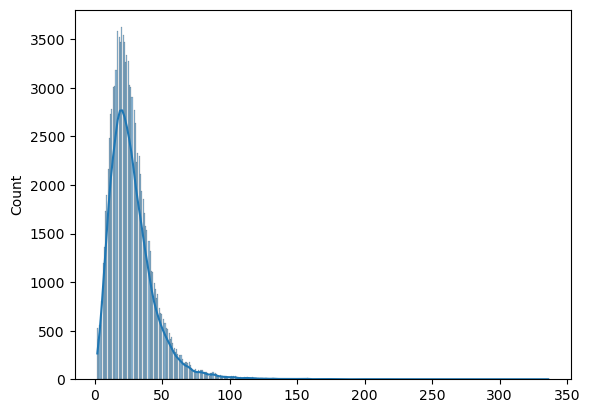

In [39]:
sent_lens = [len(sent) for sent in train_sents]
print(f"Mean length of human-written sentences, in tokens: {np.mean(sent_lens)}")
print(f"Median length of human-written sentences, in tokens: {int(np.median(sent_lens))}")
sns.histplot(sent_lens, kde=True) # in tokens

Sentences above 89 tokens removed.
Remaining sentences: 109892


<Axes: ylabel='Count'>

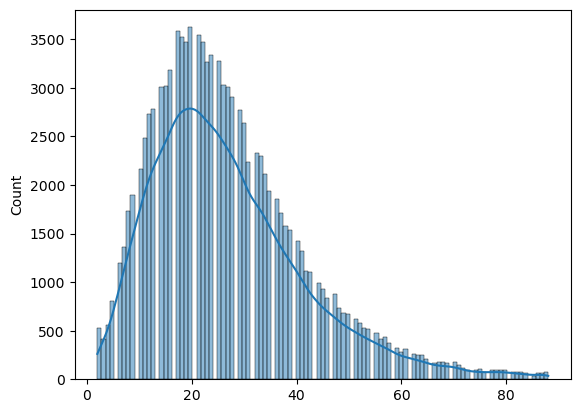

In [41]:
# clip the top 1% of sentence lengths
upper_cutoff = int(np.percentile(sent_lens, 99))
# filter out sentences above the cutoff
train_sents = [sent for sent in train_sents if len(sent) < upper_cutoff]
print(f"Sentences above {upper_cutoff} tokens removed.")
print(f"Remaining sentences: {len(train_sents)}")
sent_lens = [len(sent) for sent in train_sents]
sns.histplot(sent_lens, kde=True) # in tokens

In [42]:
humEd_train = pd.DataFrame({"human_sentence": train_sents})
humEd_train.to_parquet("data/training_data/ojs_ed/human_data_translated_20.parquet")
humEd_train.head()

,human_sentence
0,"[the, current, study, investigated, strategies..."
1,"[in, particular, the, study, aimed, at, findin..."
2,"[a, sample, of, participants, was, chosen, ran..."
3,"[semi, structured, interviews, were, used, to,..."
4,"[the, thematic, analysis, qualitative, method,..."


#### 2020 + 2021 + translated abstracts (preprocessing prior to year splits above)^^
preprocessing, saving translated English abstracts to engEd.json and non-English abstracts to multilingualEd.json

In [25]:
with open("data/json/humEd.json", "r") as infile:
    humEd = json.load(infile)
print(sum(len(articles) for articles in humEd.values()))
for month, articles in humEd.items():
    for article in articles:
        article["description"] = [unescape(article["description"][0])]

72222


In [26]:
with open("data/json/translatEd.json", "r") as infile:
    translatEd = json.load(infile)
print(sum(len(articles) for articles in translatEd.values()))

202063


Filter translated Education (English) abstract label confidence score > 0.9

In [27]:
for month, articles in tqdm(translatEd.items()):
    translatEd[month] = [article for article in articles if \
                    article.get("predicted_fos", []) and \
                    article["predicted_fos"][0][0] == "Education" and \
                    article["predicted_fos"][0][1] > 0.9]

100%|██████████| 35/35 [00:00<00:00, 78.97it/s]


In [28]:
edCounts = counts_by_month(translatEd)
edCounts

,month,count
26,2020-01-01,1121
32,2020-02-01,920
30,2020-03-01,1003
27,2020-04-01,906
34,2020-05-01,1005
24,2020-06-01,2046
28,2020-07-01,1331
29,2020-08-01,1162
25,2020-09-01,1315
33,2020-10-01,1179


In [29]:
edCounts["count"].sum()

56849

Split the translatEd dict into English and non-English

In [30]:
# Split the translatEd dict into English an non-English articles
engEd = defaultdict(list)
multilingualEd = defaultdict(list)
non_en_languages = []
for month, articles in tqdm(translatEd.items()):
    for article in articles:
        for abstract in article.get("description", []):
            abstact = unescape(abstract)
            abstract = abstract.replace("\n", " ")
            language = fasttext_model.predict(abstract)[0][0]
            if language == "__label__en":
                article_copy = article.copy()
                # change the description to be a list of len 1, containing the English abstract
                article_copy["description"] = [abstract]
                engEd[month].append(article_copy)
            else:
                article_copy = article.copy()
                # change the description to be a list of len 1, containing the non-English abstract
                article_copy["description"] = [abstract]
                article_copy["language"] = [str.replace(language, "__label__", "")]
                multilingualEd[month].append(article_copy)
                non_en_languages.append(language)
print(f"Number of English abstracts: {sum(len(articles) for articles in engEd.values())}")
print(f"Number of non-English abstracts: {sum(len(articles) for articles in multilingualEd.values())}")
# print a distribution over the non-English languages
lang_dist = pd.Series(non_en_languages).value_counts()
lang_dist

100%|██████████| 35/35 [00:11<00:00,  3.12it/s]

Number of English abstracts: 58224
Number of non-English abstracts: 70721


__label__es     21490
__label__pt     15708
__label__th      9646
__label__uk      5529
__label__ru      4000
__label__ar      3262
__label__id      2636
__label__fr      1175
__label__pl       811
__label__uz       686
__label__tg       665
__label__kk       575
__label__it       550
__label__de       499
__label__vi       470
__label__hu       439
__label__tr       356
__label__zh       267
__label__ca       248
__label__lt       215
__label__el       197
__label__sl       187
__label__ro       137
__label__sr       124
__label__is        99
__label__cs        97
__label__fi        95
__label__hr        90
__label__no        64
__label__da        55
__label__ka        51
__label__bg        40
__label__sh        39
__label__sv        38
__label__hy        34
__label__ja        28
__label__az        28
__label__eu        23
__label__ba        17
__label__fa        15
__label__gl        11
__label__ky         6
__label__sk         5
__label__ms         4
__label__ckb        3
__label__b

Filter extremely long or short abstracts, in terms of tokens

100%|██████████| 35/35 [00:18<00:00,  1.92it/s]


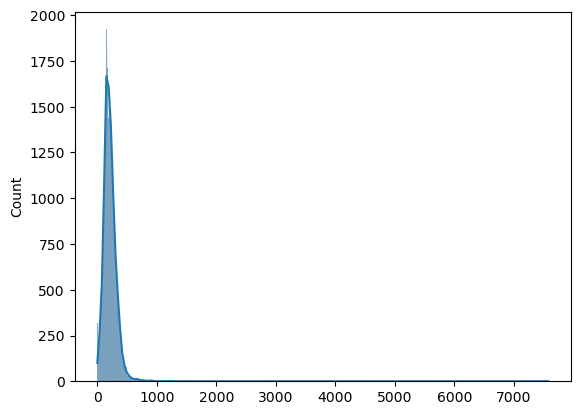

In [31]:
plot_toks(engEd)

In [32]:
en_translated_toks = [len(tokenize(article["description"][0])) for articles in tqdm(engEd.values()) for article in articles]
upper_cutoff = int(np.percentile(en_translated_toks, 99))
lower_cutoff = int(np.percentile(en_translated_toks, 4))
print(upper_cutoff)
print(lower_cutoff)

100%|██████████| 35/35 [00:14<00:00,  2.38it/s]

543
61


In [33]:
# remove Ed articles where the abstract contains more / fewer tokens than cutoffs
for month, articles in tqdm(engEd.items()):
    engEd[month] = [article for article in articles if upper_cutoff > \
                     len(tokenize(article["description"][0])) \
                        > lower_cutoff]
print(sum(len(articles) for articles in engEd.values()))

100%|██████████| 35/35 [00:14<00:00,  2.36it/s]

55249


In [34]:
en_edCounts = counts_by_month(engEd)
en_edCounts

,month,count
26,2020-01-01,1105
32,2020-02-01,832
30,2020-03-01,970
27,2020-04-01,894
34,2020-05-01,1010
24,2020-06-01,2011
28,2020-07-01,1369
29,2020-08-01,1161
25,2020-09-01,1304
33,2020-10-01,1170


100%|██████████| 35/35 [00:13<00:00,  2.51it/s]


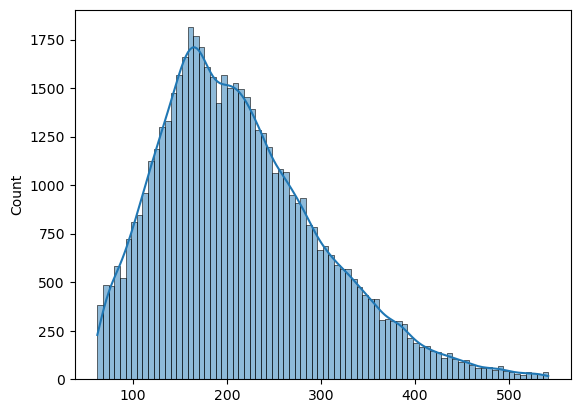

In [35]:
plot_toks(engEd)

In [36]:
with open("data/json/engEd.json", "w") as outfile:
    json.dump(engEd, outfile)

We need to use NLTK to tokenize the non-English abstracts, because spacy is trained on English

100%|██████████| 35/35 [00:28<00:00,  1.23it/s]


468
37


<Axes: ylabel='Count'>

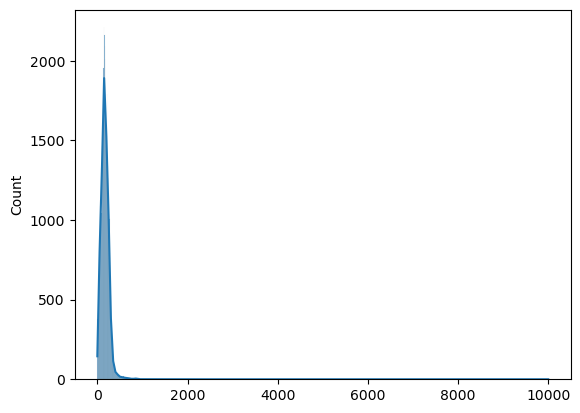

In [37]:
# use nltk to tokenize the non-English abstracts
from nltk.tokenize import word_tokenize
#nltk.download("punkt")
non_en_toks = [len(word_tokenize(article["description"][0])) for articles in tqdm(multilingualEd.values()) for article in articles]
upper_cutoff = int(np.percentile(non_en_toks, 99))
lower_cutoff = int(np.percentile(non_en_toks, 4))
print(upper_cutoff)
print(lower_cutoff)
sns.histplot(non_en_toks, kde=True)

100%|██████████| 35/35 [00:28<00:00,  1.22it/s]


67161


<Axes: ylabel='Count'>

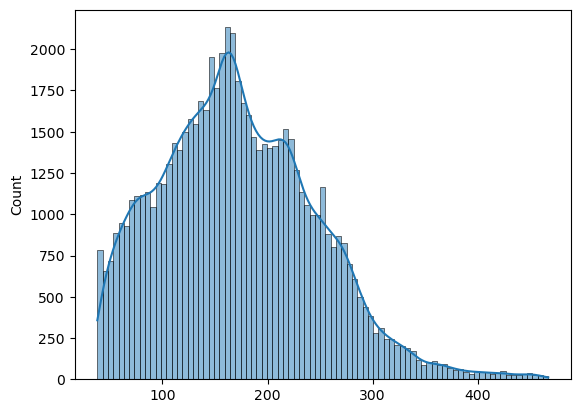

In [38]:
# remove non-English articles where the abstract contains more / fewer tokens than cutoffs
for month, articles in tqdm(multilingualEd.items()):
    multilingualEd[month] = [article for article in articles if upper_cutoff > \
                     len(word_tokenize(article["description"][0])) \
                        > lower_cutoff]
print(sum(len(articles) for articles in multilingualEd.values()))
sns.histplot([len(word_tokenize(article["description"][0])) for articles in multilingualEd.values() for article in articles], kde=True)

In [39]:
multilingual_edCounts = counts_by_month(multilingualEd)
multilingual_edCounts

,month,count
26,2020-01-01,1299
32,2020-02-01,1126
30,2020-03-01,1198
27,2020-04-01,1059
34,2020-05-01,1167
24,2020-06-01,2255
28,2020-07-01,1577
29,2020-08-01,1372
25,2020-09-01,1515
33,2020-10-01,1505


In [40]:
with open("data/json/multilingualEd.json", "w") as outfile:
    json.dump(multilingualEd, outfile)

### ChatGPT corpus: train split

#### 2021 bullet point rewritten abstracts

In [7]:
ai_abstracts = []
for file in os.listdir("prompts/templateVars/train/"):
    with open(f"prompts/templateVars/train/{file}", "r") as infile:
        if file.endswith(".json") and file.startswith("2021") and "translated" not in file:
            article = json.load(infile)
        else:
            continue
    ai_abstracts.append(article["ai_abstract"])
print(f"Number of AI abstracts: {len(ai_abstracts)}")
print(ai_abstracts[0])

Number of AI abstracts: 26894
The goal of this article is to delve into the role of learning strategy reflexed in educational processes and its impact on students' ability and self-study abilities. Additionally, it aims to examine the benefits and challenges of technology and knowledge abundance in educating students.

To achieve these objectives, the study begins by recognizing the importance of learning strategy reflexed in educational processes. It acknowledges that the way students approach their learning can greatly influence their ability to grasp and retain information. By understanding and implementing effective learning strategies, educators can enhance students' learning outcomes and promote their self-study abilities.

Furthermore, the article explores the benefits and challenges associated with the integration of technology and the abundance of knowledge in education. Technology has revolutionized the way information is accessed and disseminated, providing students with a w

100%|██████████| 26894/26894 [21:43<00:00, 20.64it/s]


Number of AI-rewritten abstracts: 26894
Mean length of abstracts, in sentences: 16.778463597828512
Median length of abstracts, in sentences: 17.0


<Axes: ylabel='Count'>

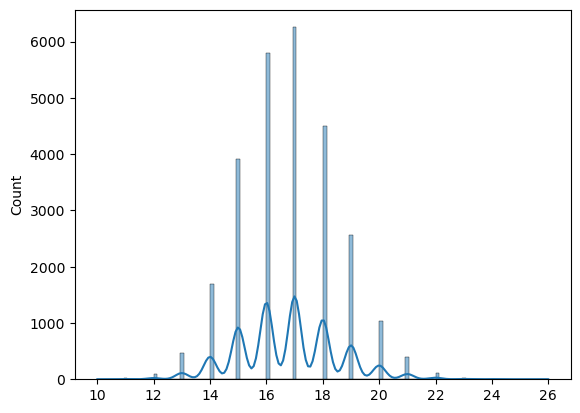

In [8]:
ai_corpus = [sent_tokenize(abstract) for abstract in tqdm(ai_abstracts)]
print(f"Number of AI-rewritten abstracts: {len(ai_corpus)}")
abstract_lens = [len(abstract) for abstract in ai_corpus]
print(f"Mean length of abstracts, in sentences: {np.mean(abstract_lens)}")
print(f"Median length of abstracts, in sentences: {np.median(abstract_lens)}")
sns.histplot(abstract_lens, kde=True) # in sentences

<Axes: ylabel='Count'>

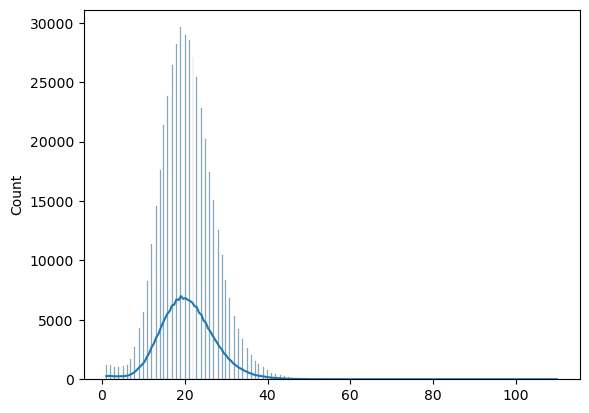

In [9]:
ai_sents = [sent for abstract in ai_corpus for sent in abstract if len(sent) > 0]
sent_lens = [len(sent) for sent in ai_sents]
sns.histplot(sent_lens, kde=True) # in tokens

In [10]:
aiEd_train = pd.DataFrame({"ai_sentence": ai_sents})
print(aiEd_train.shape[0])
aiEd_train.head()

451240


,ai_sentence
0,"[the, goal, of, this, article, is, to, delve, ..."
1,"[additionally, it, aims, to, examine, the, ben..."
2,"[to, achieve, these, objectives, the, study, b..."
3,"[it, acknowledges, that, the, way, students, a..."
4,"[by, understanding, and, implementing, effecti..."


In [11]:
aiEd_train.to_parquet("data/training_data/ojs_ed/ai_data_21.parquet")

#### 2021 translated abstracts

In [12]:
ai_abstracts = []
for file in os.listdir("prompts/templateVars/train/"):
    with open(f"prompts/templateVars/train/{file}", "r") as infile:
        if file.endswith(".json") and file.startswith("2021") and "translated" in file:
            article = json.load(infile)
        else:
            continue
    ai_abstracts.append(article["ai_abstract"])
print(f"Number of AI abstracts: {len(ai_abstracts)}")
print(ai_abstracts[0])

Number of AI abstracts: 26815
This article addresses Physical Education during the period of social distancing and school inclusion. It is a descriptive qualitative exploratory study, with the intention of understanding how distance learning in Physical Education is considered for students who are considered inclusive. A survey was conducted with 43 teachers through the distribution of a questionnaire. Changes and adaptations in the curriculum and classes were identified, as well as difficulties in accessing technologies and reduced contact between teachers and students. It is understood that maintaining the bond/learning, teacher training, and recognition of this work are important demands in this process. It is emphasized that differences should be present in school contexts, promoting human development.


100%|██████████| 26815/26815 [14:39<00:00, 30.49it/s]


Number of AI-rewritten abstracts: 26815
Mean length of abstracts, in sentences: 9.175237740070855
Median length of abstracts, in sentences: 8.0


<Axes: ylabel='Count'>

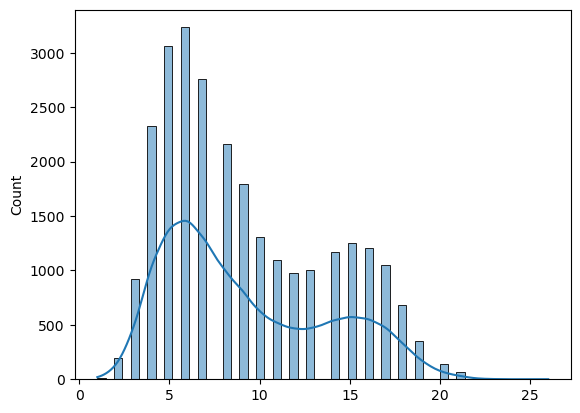

In [13]:
ai_corpus = [sent_tokenize(abstract) for abstract in tqdm(ai_abstracts)]
print(f"Number of AI-rewritten abstracts: {len(ai_corpus)}")
abstract_lens = [len(abstract) for abstract in ai_corpus]
print(f"Mean length of abstracts, in sentences: {np.mean(abstract_lens)}")
print(f"Median length of abstracts, in sentences: {np.median(abstract_lens)}")
sns.histplot(abstract_lens, kde=True) # in sentences

<Axes: ylabel='Count'>

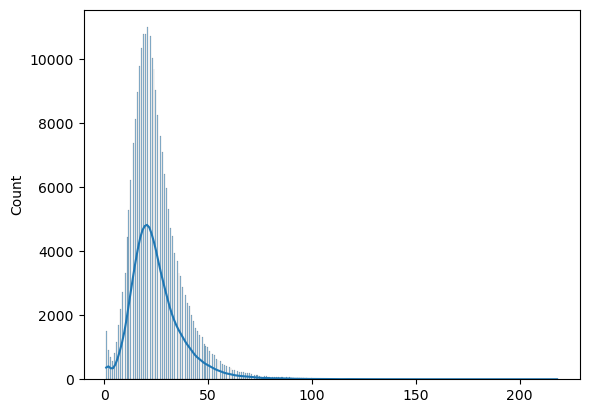

In [14]:
ai_sents = [sent for abstract in ai_corpus for sent in abstract if len(sent) > 0]
sent_lens = [len(sent) for sent in ai_sents]
sns.histplot(sent_lens, kde=True) # in tokens

In [15]:
aiEd_train = pd.DataFrame({"ai_sentence": ai_sents})
print(aiEd_train.shape[0])
aiEd_train.head()

246034


,ai_sentence
0,"[this, article, addresses, physical, education..."
1,"[it, is, a, descriptive, qualitative, explorat..."
2,"[a, survey, was, conducted, with, teachers, th..."
3,"[changes, and, adaptations, in, the, curriculu..."
4,"[it, is, understood, that, maintaining, the, b..."


In [16]:
aiEd_train.to_parquet("data/training_data/ojs_ed/ai_data_translated_21.parquet")

#### 2020 bullet point rewritten abstracts

In [17]:
ai_abstracts = []
for file in os.listdir("prompts/templateVars/train/"):
    with open(f"prompts/templateVars/train/{file}", "r") as infile:
        if file.endswith(".json") and file.startswith("2020") and "translated" not in file:
            article = json.load(infile)
        else:
            continue
    ai_abstracts.append(article["ai_abstract"])
print(f"Number of AI abstracts: {len(ai_abstracts)}")
print(ai_abstracts[0])

Number of AI abstracts: 19118
The goal of this article is to explore the relationship between culture and education in Nigeria and propose principles for an effective culture-based education system. Culture and education are deeply interconnected, and it is crucial for education to address the cultural needs of a society. However, in Nigeria, the education system often falls short in effectively responding to social challenges and meeting the cultural needs of its diverse population.

To examine the conditions of Nigerian education, this research employs analytical and prescriptive methods of philosophy. By critically analyzing the existing education system, the study aims to identify the gaps and shortcomings that hinder the integration of culture into education. The research also seeks to identify the elements of a culture-based education system that are aligned with the characteristics of Nigerian culture.

Through a comprehensive analysis, this article identifies several key elemen

100%|██████████| 19118/19118 [15:29<00:00, 20.56it/s]


Number of AI-rewritten abstracts: 19118
Mean length of abstracts, in sentences: 16.755936813474214
Median length of abstracts, in sentences: 17.0


<Axes: ylabel='Count'>

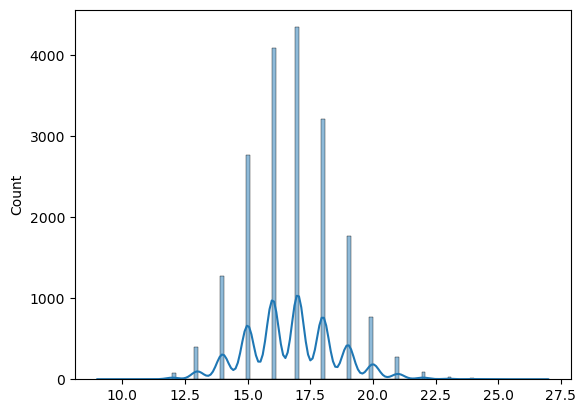

In [18]:
ai_corpus = [sent_tokenize(abstract) for abstract in tqdm(ai_abstracts)]
print(f"Number of AI-rewritten abstracts: {len(ai_corpus)}")
abstract_lens = [len(abstract) for abstract in ai_corpus]
print(f"Mean length of abstracts, in sentences: {np.mean(abstract_lens)}")
print(f"Median length of abstracts, in sentences: {np.median(abstract_lens)}")
sns.histplot(abstract_lens, kde=True) # in sentences

<Axes: ylabel='Count'>

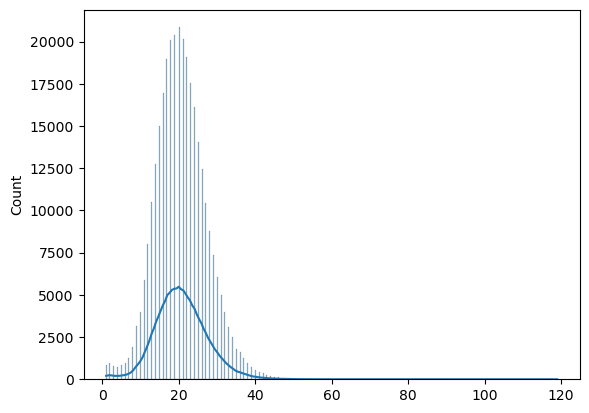

In [19]:
ai_sents = [sent for abstract in ai_corpus for sent in abstract if len(sent) > 0]
sent_lens = [len(sent) for sent in ai_sents]
sns.histplot(sent_lens, kde=True) # in tokens

In [20]:
aiEd_train = pd.DataFrame({"ai_sentence": ai_sents})
print(aiEd_train.shape[0])
aiEd_train.head()

320340


,ai_sentence
0,"[the, goal, of, this, article, is, to, explore..."
1,"[culture, and, education, are, deeply, interco..."
2,"[however, in, nigeria, the, education, system,..."
3,"[to, examine, the, conditions, of, nigerian, e..."
4,"[by, critically, analyzing, the, existing, edu..."


In [21]:
aiEd_train.to_parquet("data/training_data/ojs_ed/ai_data_20.parquet")

## Validation
Jan-Nov 2022 data

### Monolingual English validation data

In [7]:
with open("data/json/humEd.json", "r") as infile:
    humEd = json.load(infile)
val = {} # Jan - Nov 2022
for month, articles in humEd.items():
    if month.endswith("22"):
        val[month] = articles
val_abstracts = [article["description"][0] for articles in val.values() for article in articles]
print(f"Number of human-written abstracts: {len(val_abstracts)}")
counts_by_month(val)

Number of human-written abstracts: 26094


,month,count
10,2022-01-01,2017
2,2022-02-01,2039
8,2022-03-01,2273
0,2022-04-01,2359
4,2022-05-01,2182
7,2022-06-01,3632
5,2022-07-01,2098
6,2022-08-01,2043
1,2022-09-01,2233
3,2022-10-01,2353


In [8]:
ai_abstracts = []
for file in os.listdir("prompts/templateVars/val"):
    with open(f"prompts/templateVars/val/{file}", "r") as infile:
        if file.endswith(".json") and file.startswith("2022") and "translated" not in file:
            article = json.load(infile)
        else:
            continue
    ai_abstracts.append(article["ai_abstract"])
print(f"Number of ChatGPT rewritten abstracts: {len(ai_abstracts)}")
print(ai_abstracts[0])

Number of ChatGPT rewritten abstracts: 6568
The main goal of this article is to provide an in-depth overview of the education system in Central Asia during the late 20th and early 21st centuries, with a specific focus on the countries that gained independence from the Soviet Union. Central Asia, comprising Kazakhstan, Kyrgyzstan, Tajikistan, Turkmenistan, and Uzbekistan, experienced significant changes in their education systems following the collapse of the USSR. 

The article begins by examining the historical context of the education systems in these countries, tracing their development from the Soviet era to the present day. It explores the key policies and practices that shaped the education landscape during this period, highlighting the influence of Soviet ideology and the centralization of educational decision-making. 

One of the main objectives of this article is to identify the shortcomings and challenges faced by the education systems in Central Asia after gaining independen

In [9]:
val_corpus = [sent_tokenize(abstract) for abstract in tqdm(val_abstracts, desc="Sentence tokenizing human abstracts")]
ai_corpus = [sent_tokenize(abstract) for abstract in tqdm(ai_abstracts, desc="Sentence tokenizing AI abstracts")]
val_sents = [sent for abstract in val_corpus for sent in abstract if len(sent) > 1]
ai_sents = [sent for abstract in ai_corpus for sent in abstract if len(sent) > 1]
print(f"Human sentences: {len(val_sents)}")
print(f"AI sentences: {len(ai_sents)}")

Sentence tokenizing AI abstracts: 100%|██████████| 6568/6568 [05:15<00:00, 20.85it/s]


Human sentences: 196928
AI sentences: 110045


In [10]:
for alpha in [0, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25]:
    num_ai_sents = int(len(val_sents) * alpha)
    sampled_ai_sents = random.sample(ai_sents, num_ai_sents)
    sampled_human_sents = random.sample(val_sents, len(val_sents) - num_ai_sents)
    val_set = pd.DataFrame({"inference_sentence": sampled_ai_sents + sampled_human_sents})
    val_set.to_parquet(f"data/validation_data/ojs_ed/ground_truth_alpha_{alpha}.parquet")
    print(f"Generated validation set with alpha={alpha}, containing {len(val_set)} sentences.")

Generated validation set with alpha=0, containing 196928 sentences.
Generated validation set with alpha=0.025, containing 196928 sentences.
Generated validation set with alpha=0.05, containing 196928 sentences.
Generated validation set with alpha=0.075, containing 196928 sentences.
Generated validation set with alpha=0.1, containing 196928 sentences.
Generated validation set with alpha=0.125, containing 196928 sentences.
Generated validation set with alpha=0.15, containing 196928 sentences.
Generated validation set with alpha=0.175, containing 196928 sentences.
Generated validation set with alpha=0.2, containing 196928 sentences.
Generated validation set with alpha=0.225, containing 196928 sentences.
Generated validation set with alpha=0.25, containing 196928 sentences.


### Translated English validation data

In [7]:
with open("data/json/engEd.json", "r") as infile:
    engEd = json.load(infile)
val = {} # Jan - Nov 2022
for month, articles in engEd.items():
    if month.endswith("22"):
        val[month] = articles
val_abstracts = [unescape(article["description"][0]) for articles in val.values() for article in articles]
print(f"Number of human (+google?) abstracts: {len(val_abstracts)}")
counts_by_month(val)

Number of human (+google?) abstracts: 17385


,month,count
10,2022-01-01,1656
2,2022-02-01,1044
8,2022-03-01,1558
0,2022-04-01,1541
4,2022-05-01,1441
7,2022-06-01,2698
5,2022-07-01,1588
6,2022-08-01,1487
1,2022-09-01,1564
3,2022-10-01,1351


In [8]:
ai_abstracts = []
for file in os.listdir("prompts/templateVars/val"):
    with open(f"prompts/templateVars/val/{file}", "r") as infile:
        if file.endswith(".json") and file.startswith("2022") and "translated" in file:
            article = json.load(infile)
        else:
            continue
    ai_abstracts.append(article["ai_abstract"])
print(f"Number of ChatGPT rewritten abstracts: {len(ai_abstracts)}")
print(ai_abstracts[0])

Number of ChatGPT rewritten abstracts: 5195
The abstract provides information about the principles and regulations of pedagogy in vocational education, as well as the conditions for the implementation of the technical principle. It also highlights the principles of education and upbringing. The article focuses on the students' attitudes towards the educational process and the importance of pedagogical principles in shaping their knowledge and skills.

The study explores the role of pedagogical principles in the educational process of students in vocational education. It emphasizes the significance of these principles in guiding the teaching and learning activities. The authors discuss the importance of adhering to pedagogical regulations and principles in order to create an effective learning environment.

The article also delves into the regulations and principles of pedagogy in vocational education. It highlights the need for educators to be familiar with these regulations and princi

In [9]:
val_corpus = [sent_tokenize(abstract) for abstract in tqdm(val_abstracts, desc="Sentence tokenizing human abstracts")]
ai_corpus = [sent_tokenize(abstract) for abstract in tqdm(ai_abstracts, desc="Sentence tokenizing AI abstracts")]
val_sents = [sent for abstract in val_corpus for sent in abstract if len(sent) > 1]
ai_sents = [sent for abstract in ai_corpus for sent in abstract if len(sent) > 1]
print(f"Human sentences: {len(val_sents)}")
print(f"AI sentences: {len(ai_sents)}")

Sentence tokenizing AI abstracts: 100%|██████████| 5195/5195 [02:53<00:00, 30.00it/s]

Human sentences: 119340
AI sentences: 46502


In [10]:
for alpha in [0, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25]:
    num_ai_sents = int(len(val_sents) * alpha)
    sampled_ai_sents = random.sample(ai_sents, num_ai_sents)
    sampled_human_sents = random.sample(val_sents, len(val_sents) - num_ai_sents)
    val_set = pd.DataFrame({"inference_sentence": sampled_ai_sents + sampled_human_sents})
    val_set.to_parquet(f"data/validation_data/ojs_ed/translated/ground_truth_alpha_{alpha}.parquet")
    print(f"Generated validation set with alpha={alpha}, containing {len(val_set)} sentences.")

Generated validation set with alpha=0, containing 119340 sentences.
Generated validation set with alpha=0.025, containing 119340 sentences.
Generated validation set with alpha=0.05, containing 119340 sentences.
Generated validation set with alpha=0.075, containing 119340 sentences.
Generated validation set with alpha=0.1, containing 119340 sentences.
Generated validation set with alpha=0.125, containing 119340 sentences.
Generated validation set with alpha=0.15, containing 119340 sentences.
Generated validation set with alpha=0.175, containing 119340 sentences.
Generated validation set with alpha=0.2, containing 119340 sentences.
Generated validation set with alpha=0.225, containing 119340 sentences.
Generated validation set with alpha=0.25, containing 119340 sentences.


## Test
Jan 2023 - Mar 2024 data